## License

Copyright 2021 - 2023 Patrick Hall (jphall@gwu.edu) and Carissa Paul (carissa.paul@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

*DISCLAIMER*: This notebook is not legal or compliance advice.

# Assignment 4 Template
With two calls to a blackbox prediction API we can craft adversarial examples to manipulate the model toward higher and lower predictions.

#### Imports and inits

In [1]:
!pip install interpret h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 26.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━

In [2]:
import h2o                                                        # h2o python library
from h2o.backend import H2OLocalServer                            # for model extraction
from h2o.estimators.random_forest import H2ORandomForestEstimator # for decision tree in model extraction
from interpret.glassbox import ExplainableBoostingClassifier      # interpret ebm class
from interpret.perf import ROC                                    # ROC measure for ebm
import matplotlib.pyplot as plt                                   # for plots
import numpy as np                                                # for basic array manipulation
import pandas as pd                                               # for dataframe manipulation
import subprocess                                                 # to run external processes for model extraction
import time                                                       # for timers

# enables display of images in notebook
from IPython.display import Image
from IPython.display import display

# set numpy random seed for better reproducibility
SEED = 12345
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='2G')      # start h2o
h2o.remove_all()                 # remove any existing data structures from h2o memory
h2o.no_progress()                # turn off h2o progress indicators

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpoud5kotn
  JVM stdout: /tmp/tmpoud5kotn/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpoud5kotn/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,08 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_unknownUser_8yyyi5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


### Define Utility Functions

#### Utility function that trains a cross-validated decision tree

In [3]:
def get_cv_dt(x_names, y_name, train, model_id, seed_, title, valid=None):

    """ Utility function to train decision trees.
    Args:
        x_names: Names of input variables as a list.
        y_name: Name of target variable.
        train: Pandas DataFrame containing x_names and y_name on which to train
               decision tree.
        model_id: h2o model identifier.
        seed_: Random seed for improved reproducibility.
        title: Title for generated plot of tree.
        valid: Optional validation data.
    Returns:
        Model as h2o model object.
    """

    # initialize single tree model
    tree = H2ORandomForestEstimator(ntrees=1,  # use only one tree
                                    sample_rate=1,  # use all rows in that tree
                                    mtries=-2,  # use all columns in that tree's split search
                                    max_depth=4,  # shallow trees are easier to understand
                                    seed=seed_,  # set random seed for reproducibility
                                    nfolds=3,  # cross-validation for stability and ...
                                    # only way to get metrics for 1 tree in h2o
                                    model_id=model_id)  # gives MOJO artifact a recognizable name

    # train single tree model
    if valid is not None:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train), validation_frame=h2o.H2OFrame(valid))
    else:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train))

    # persist MOJO (compiled Java representation of trained model)
    # from which to generate plot of tree
    mojo_path = tree.download_mojo(path='.')
    print('Generated MOJO path:\n', mojo_path)

    return tree

#### Utility function to calculate confusion matrix


In [4]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced
        by a variable and level.

        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Name of actual value column.
        :param yhat: Name of predicted value column.
        :param by: By variable to slice frame before creating confusion matrix, default None.
        :param level: Value of by variable to slice frame before creating confusion matrix, default None.
        :param cutoff: Cutoff threshold for confusion matrix, default 0.5.
        :param verbose: Whether to print confusion matrix titles, default True.
        :return: Confusion matrix as pandas dataframe.

    """

    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list],
                            index=['predicted: ' + str(i) for i in level_list])

    # don't destroy original data
    frame_ = frame.copy(deep=True)

    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)

    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]

    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
            # i, j vs. j, i nasty little bug ... updated 8/30/19

    # output results
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))

    return cm_frame

#### Utility function to calculate AIR

In [5]:
def air(cm_dict, reference_key, protected_key, verbose=True):

    """ Calculates the adverse impact ratio as a quotient between protected and
        reference group acceptance rates: protected_prop/reference_prop.
        Optionally prints intermediate values. ASSUMES 0 IS "POSITIVE" OUTCOME!

        :param cm_dict: Dictionary of demographic group confusion matrices.
        :param reference_key: Name of reference group in cm_dict as a string.
        :param protected_key: Name of protected group in cm_dict as a string.
        :param verbose: Whether to print intermediate acceptance rates, default True.
        :return: AIR.

    """

    eps = 1e-20 # numeric stability and divide by 0 protection

    # reference group summary
    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)

    # protected group summary
    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)

    # return adverse impact ratio
    if np.isclose(protected_accepted, 0.0):
        return np.nan
    else:
        return ((protected_prop + eps)/(reference_prop + eps))


In [6]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
# may need to be updated to location on your drive
%cd drive/My\ Drive/DNSC_6330_Software/assignments/
%ls

Mounted at /content/drive/
/content/drive/My Drive/DNSC_6330_Software/assignments
assign_1_template.ipynb  ph_rem_ebm_2025_04_05_05_40_35.csv  stolen_dt.gv
assign_2_template.ipynb  ph_rem_ebm_2025_04_05_23_29_58.csv  stolen_dt.png
assign_3_template.ipynb  ph_rem_ebm_2025_04_06_22_17_12.csv  stolen_dt.zip
assign_4_template.ipynb  ph_rem_ebm_2025_04_07_01_20_15.csv


#### Start global timer

In [7]:
tic = time.time()

#### Import data

In [8]:
data = pd.read_csv('../data/hmda_train_preprocessed.csv')

#### Assign basic modeling roles

In [9]:
y_name = 'high_priced'

## Fit interpretable model

#### Split data into train and validation partitions

In [10]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Explainable Boosting Machine

#### Retrain most accurate model above 0.8 AIR to act as blackbox prediction API

In [11]:
'''# params dict for remediated models
rem_params = {'max_bins': 512,
              'max_interaction_bins': 16,
              'interactions': 10,
              'outer_bags': 4,
              'inner_bags': 0,
              'learning_rate': 0.001,
              'validation_size': 0.25,
              'min_samples_leaf': 5,
              'max_leaves': 5,
              'early_stopping_rounds': 100.0,
              'n_jobs': NTHREAD,
              'random_state': SEED} # YOUR MODEL PARAMETERS HERE!

rem_x_names = ['property_value_std',
               'no_intro_rate_period_std',
               'loan_amount_std',
               'income_std',
               'conforming',
               'intro_rate_period_std',
               'debt_to_income_ratio_std',
               'term_360'] # YOUR FEATURES HERE!

# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])
rem_params['early_stopping_rounds'] = int(rem_params['early_stopping_rounds'])

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name])
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)'''

"# params dict for remediated models\nrem_params = {'max_bins': 512,\n              'max_interaction_bins': 16,\n              'interactions': 10,\n              'outer_bags': 4,\n              'inner_bags': 0,\n              'learning_rate': 0.001,\n              'validation_size': 0.25,\n              'min_samples_leaf': 5,\n              'max_leaves': 5,\n              'early_stopping_rounds': 100.0,\n              'n_jobs': NTHREAD,\n              'random_state': SEED} # YOUR MODEL PARAMETERS HERE!\n\nrem_x_names = ['property_value_std',\n               'no_intro_rate_period_std',\n               'loan_amount_std',\n               'income_std',\n               'conforming',\n               'intro_rate_period_std',\n               'debt_to_income_ratio_std',\n               'term_360'] # YOUR FEATURES HERE!\n\n# reset some parameters to integers\nrem_params['random_state'] = int(rem_params['random_state'])\nrem_params['n_jobs'] = int(rem_params['n_jobs'])\nrem_params['early_stopping

In [12]:
rem_params = {
    'max_bins': 1024,                 # finer binning for continuous features
    'max_interaction_bins': 64,      # allow richer interaction patterns
    'interactions': 20,              # model more pairwise effects
    'outer_bags': 10,                # better ensemble averaging
    'inner_bags': 0,
    'learning_rate': 0.01,           # modest boost to learning
    'validation_size': 0.2,          # slightly more data for training
    'min_samples_leaf': 2,           # allow smaller leaves
    'max_leaves': 20,                # more complex trees per feature
    'early_stopping_rounds': 100,
    'n_jobs': int(NTHREAD),
    'random_state': int(SEED)
}

rem_x_names = ['property_value_std', 'no_intro_rate_period_std', 'loan_amount_std', 'income_std', 'conforming', 'intro_rate_period_std', 'debt_to_income_ratio_std', 'term_360']
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name])
rem_auc = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])._internal_obj['overall']['auc']
print('Tuned AUC: %.4f' % rem_auc)


Tuned AUC: 0.8127


In [13]:
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name])

# Get predictions for training & validation
train_preds = rem_ebm.predict_proba(train[rem_x_names])[:, 1]
valid_preds = rem_ebm.predict_proba(valid[rem_x_names])[:, 1]


In [14]:
from sklearn.linear_model import LogisticRegression

# Create new training set using EBM output
X_train_stack = pd.DataFrame({'ebm_pred': train_preds})
X_valid_stack = pd.DataFrame({'ebm_pred': valid_preds})

meta_model = LogisticRegression()
meta_model.fit(X_train_stack, train[y_name])

LogisticRegression()

In [15]:
from sklearn.metrics import roc_auc_score

stacked_preds = meta_model.predict_proba(X_valid_stack)[:, 1]
stacked_auc = roc_auc_score(valid[y_name], stacked_preds)
print('Stacked AUC: %.4f' % stacked_auc)

Stacked AUC: 0.8127


## Model Extraction Attack

#### Generate synthetic data for extraction attack
For an API or model to be usable by customers or others, the system documentation must contain basic information about expected input variables. Between that information, domain knowledge, and publicly available information, an attacker can make a good guess at what the input data should look like.

In [16]:
'''# best guess at feature distributions
schema_dict = {'term_360':                     {'p': 0.9, 'dist': 'binomial'},
               'conforming':                   {'p': 0.9, 'dist': 'binomial'},
               'no_intro_rate_period_std':     {'p': 0.1, 'dist': 'binomial'},
               'loan_amount_std':              {'min': -5, 'scale': 10, 'dist': 'exponential'},
               'intro_rate_period_std':        {'min': 0, 'scale': 2, 'dist': 'exponential'},
               'property_value_std':           {'min': -5, 'scale': 5, 'dist': 'exponential'},
               'income_std':                   {'min': -5, 'scale': 25, 'dist': 'exponential'},
               'debt_to_income_ratio_std':     {'mean': 1, 'scale': 1, 'dist': 'normal'}}

N = 10000 # rows of simulated data

random_frame = pd.DataFrame(columns=list(schema_dict.keys())) # init empty frame

np.random.seed(SEED) # same results each time cell is run

for j in list(schema_dict.keys()): # loop through features

    # simulate normal features
    if schema_dict[j]['dist'] == 'normal':
        random_frame[j] = np.random.normal(loc=schema_dict[j]['mean'],
                                           scale=schema_dict[j]['scale'],
                                           size=N)

    # simulate expontential features
    if schema_dict[j]['dist'] == 'exponential':
        random_frame[j] = schema_dict[j]['min'] + np.random.exponential(scale=schema_dict[j]['scale'],
                                                                        size=N)

    # simulate binomial features
    if schema_dict[j]['dist'] == 'binomial':
        random_frame[j] = np.random.binomial(1, schema_dict[j]['p'], N)

# make up for no_intro_rate_period_std scale shift
random_frame['no_intro_rate_period_std'] = -4 * random_frame['no_intro_rate_period_std']'''

"# best guess at feature distributions\nschema_dict = {'term_360':                     {'p': 0.9, 'dist': 'binomial'},\n               'conforming':                   {'p': 0.9, 'dist': 'binomial'},\n               'no_intro_rate_period_std':     {'p': 0.1, 'dist': 'binomial'},\n               'loan_amount_std':              {'min': -5, 'scale': 10, 'dist': 'exponential'},\n               'intro_rate_period_std':        {'min': 0, 'scale': 2, 'dist': 'exponential'},\n               'property_value_std':           {'min': -5, 'scale': 5, 'dist': 'exponential'},\n               'income_std':                   {'min': -5, 'scale': 25, 'dist': 'exponential'},\n               'debt_to_income_ratio_std':     {'mean': 1, 'scale': 1, 'dist': 'normal'}}\n\nN = 10000 # rows of simulated data\n\nrandom_frame = pd.DataFrame(columns=list(schema_dict.keys())) # init empty frame\n\nnp.random.seed(SEED) # same results each time cell is run\n\nfor j in list(schema_dict.keys()): # loop through features\

In [17]:
import numpy as np
import pandas as pd

SEED = 10000  # Set seed for reproducibility
np.random.seed(SEED)

# Schema dictionary describing distributions
schema_dict = {
    'term_360': {'p': 0.9, 'dist': 'binomial'},
    'conforming': {'p': 0.9, 'dist': 'binomial'},
    'no_intro_rate_period_std': {'p': 0.1, 'dist': 'binomial'},
    'loan_amount_std': {'min': -5, 'scale': 10, 'dist': 'exponential'},
    'intro_rate_period_std': {'min': 0, 'scale': 2, 'dist': 'exponential'},
    'property_value_std': {'min': -5, 'scale': 5, 'dist': 'exponential'},
    'income_std': {'min': -5, 'scale': 25, 'dist': 'exponential'},
    'debt_to_income_ratio_std': {'mean': 1, 'scale': 1, 'dist': 'normal'}
}

N = 10000  # Number of samples
random_frame = pd.DataFrame(columns=schema_dict.keys())  # Initialize empty DataFrame

# Generate synthetic data
for feature, params in schema_dict.items():
    if params['dist'] == 'normal':
        random_frame[feature] = np.random.normal(loc=params['mean'], scale=params['scale'], size=N)
    elif params['dist'] == 'exponential':
        random_frame[feature] = params['min'] + np.random.exponential(scale=params['scale'], size=N)
    elif params['dist'] == 'binomial':
        random_frame[feature] = np.random.binomial(1, params['p'], size=N)

# Apply scale shift for specific feature
random_frame['no_intro_rate_period_std'] *= -4

# Preview
print(random_frame.head())


   term_360  conforming  no_intro_rate_period_std  loan_amount_std  \
0         1           1                         0        10.167948   
1         1           1                         0        -0.946284   
2         1           1                         0        14.995469   
3         1           1                         0        -0.230370   
4         1           1                         0         7.032699   

   intro_rate_period_std  property_value_std  income_std  \
0               5.291502           -3.594271   13.562852   
1               3.636646           -1.618879   42.881082   
2               7.494371           -1.973195   11.432224   
3               1.341514           -3.333340   -3.545714   
4               0.041901           -3.894340    4.735984   

   debt_to_income_ratio_std  
0                  2.724924  
1                 -0.483899  
2                  2.648105  
3                  2.635140  
4                  0.911568  


#### Visualize simulated data

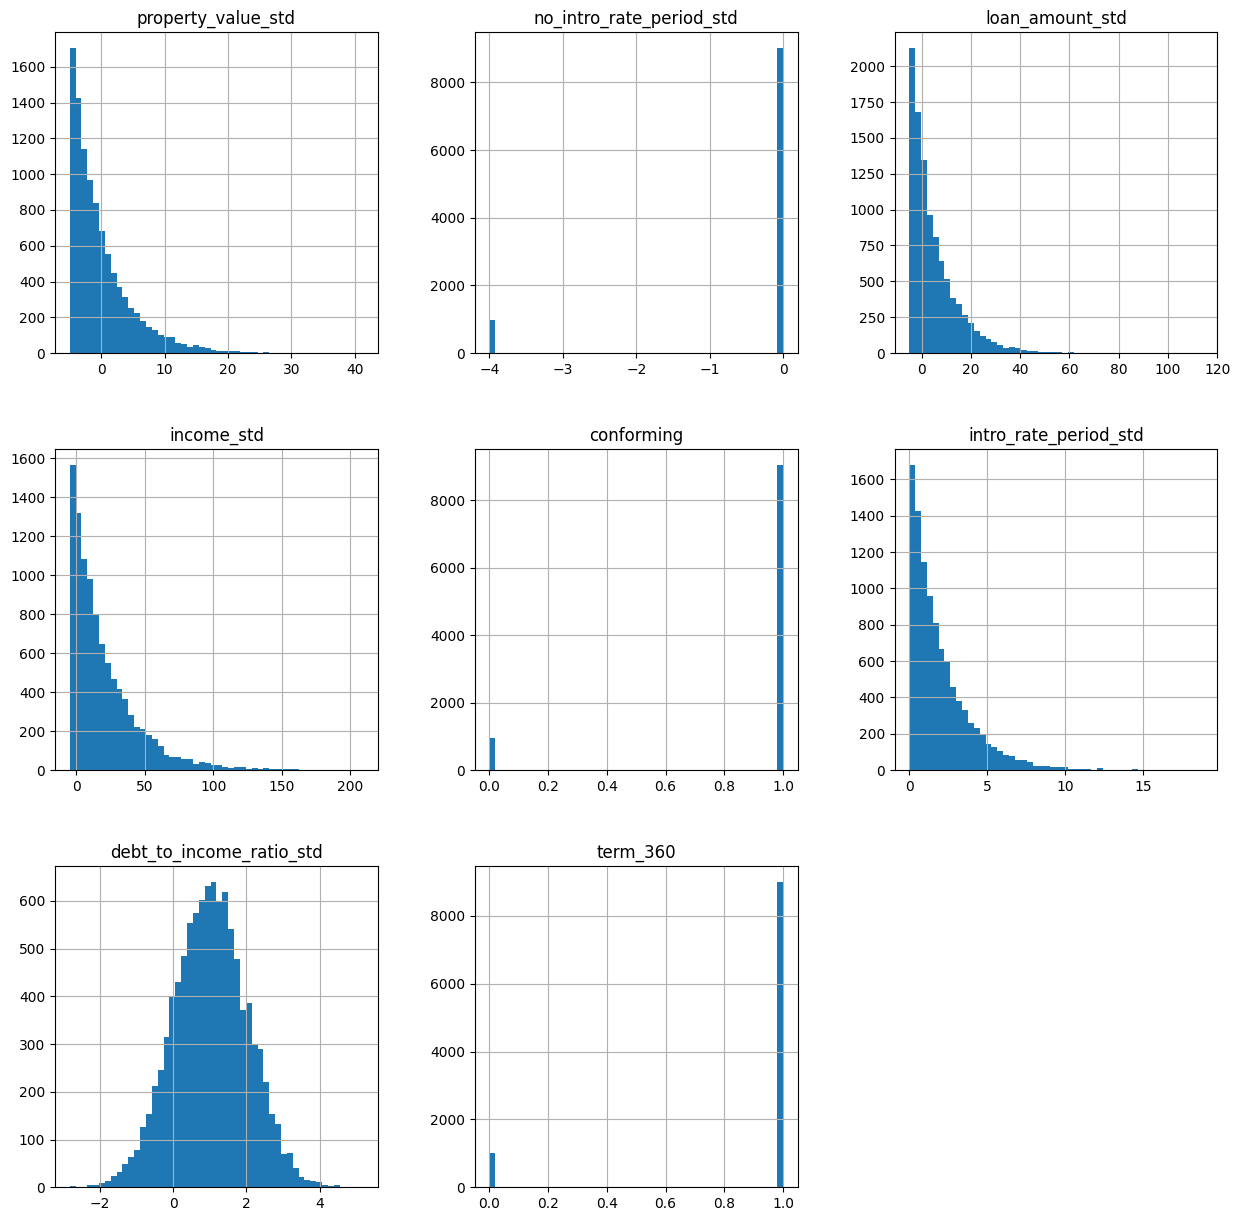

In [18]:
_ = random_frame[rem_x_names].hist(bins=50, figsize=(15, 15))

#### First call to blackbox model for predictions on random data

In [19]:
blackbox_phat = pd.DataFrame(rem_ebm.predict_proba(random_frame[rem_x_names])[:, 1], columns=['phat'])
blackbox_phat = pd.concat([random_frame.reset_index(drop=True), blackbox_phat], axis=1)
blackbox_phat.head()

,term_360,conforming,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,phat
0,1,1,0,10.167948,5.291502,-3.594271,13.562852,2.724924,6.960642e-05
1,1,1,0,-0.946284,3.636646,-1.618879,42.881082,-0.483899,1.140201e-04
2,1,1,0,14.995469,7.494371,-1.973195,11.432224,2.648105,4.213777e-07
3,1,1,0,-0.230370,1.341514,-3.333340,-3.545714,2.635140,1.072553e-03
4,1,1,0,7.032699,0.041901,-3.894340,4.735984,0.911568,1.769658e-02


#### Extract a stolen decision tree model

In [20]:
stolen_dt = get_cv_dt(list(schema_dict.keys()),
                      'phat',
                      blackbox_phat,
                      'stolen_dt',
                      SEED,
                      'Stolen Model')

# convert h2o MOJO (stolen_dt.zip) into GraphViz file (stolen_dt.png)
!java -cp "/usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar" hex.genmodel.tools.PrintMojo --tree 0 -i "stolen_dt.zip" -o stolen_dt.gv --title "Stolen Model"

# convert Graphviz file into png
!dot -Tpng stolen_dt.gv -o stolen_dt.png

# three new files should appear:
# - stolen_dt.zip
# - stolen_dt.gv
# - stolen_dt.png
%ls

Generated MOJO path:
 /content/drive/My Drive/DNSC_6330_Software/assignments/stolen_dt.zip
assign_1_template.ipynb  ph_rem_ebm_2025_04_05_05_40_35.csv  stolen_dt.gv
assign_2_template.ipynb  ph_rem_ebm_2025_04_05_23_29_58.csv  stolen_dt.png
assign_3_template.ipynb  ph_rem_ebm_2025_04_06_22_17_12.csv  stolen_dt.zip
assign_4_template.ipynb  ph_rem_ebm_2025_04_07_01_20_15.csv


#### View stolen model
Double clicking should zoom.

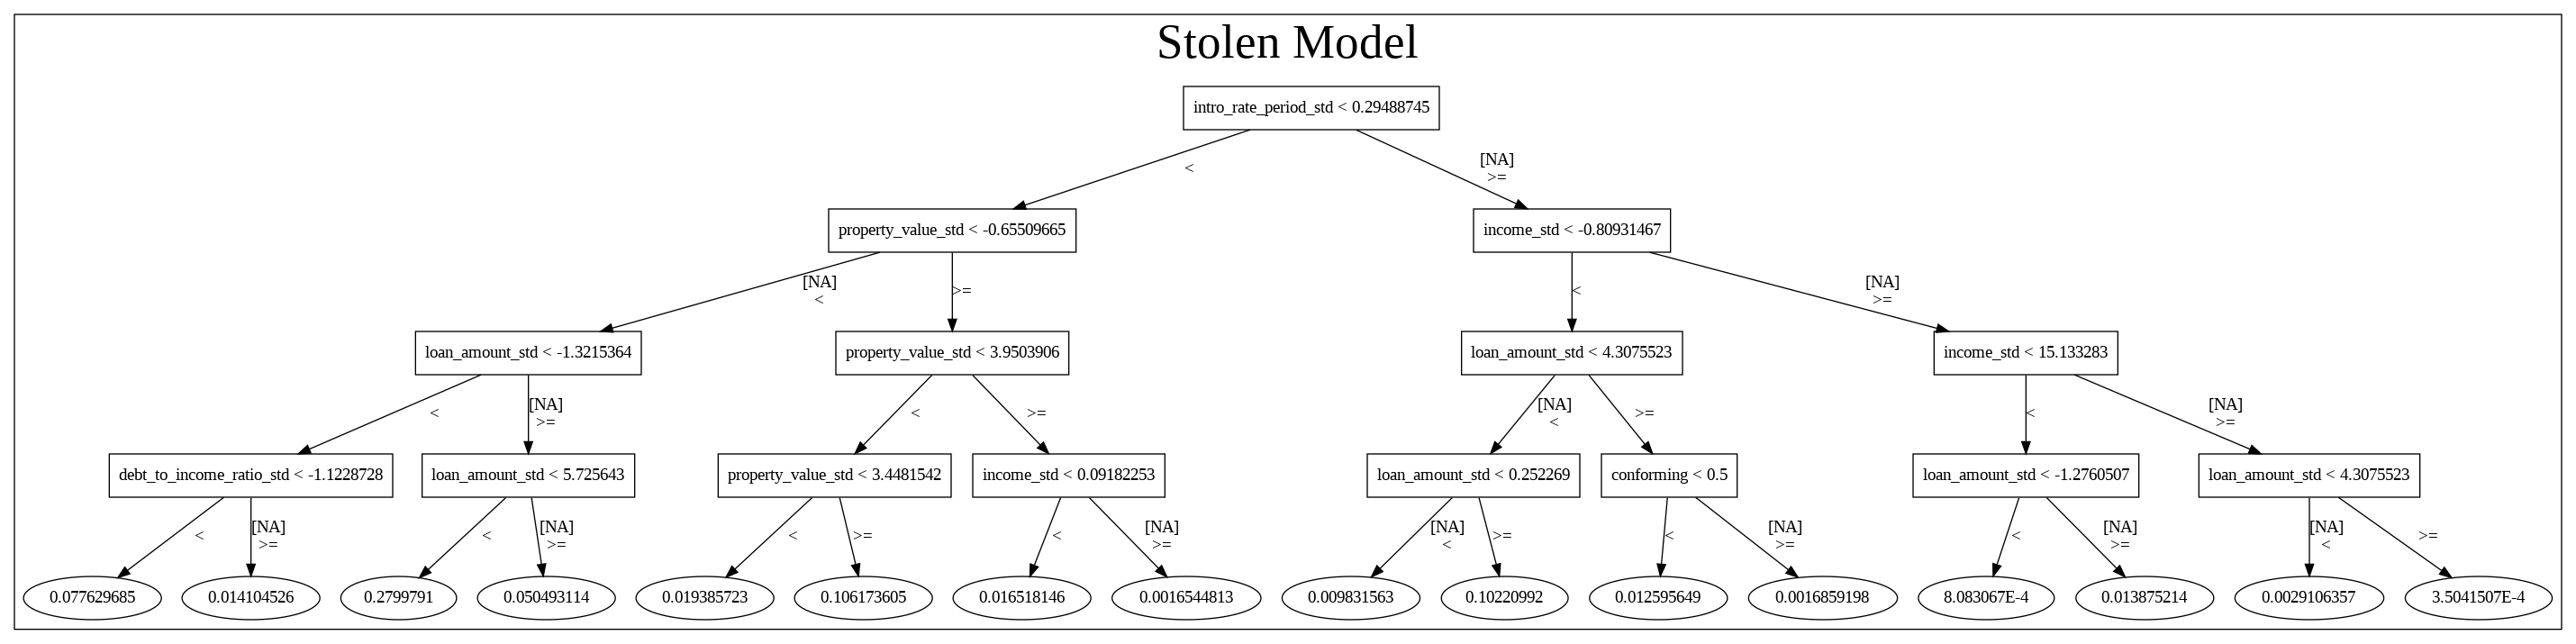

In [21]:
display(Image(('stolen_dt.png')))

Now an attacker has a basic flow chart for how the EBM works. This can be used as a sandbox for subsequent attacks!

#### Variable importance for stolen model

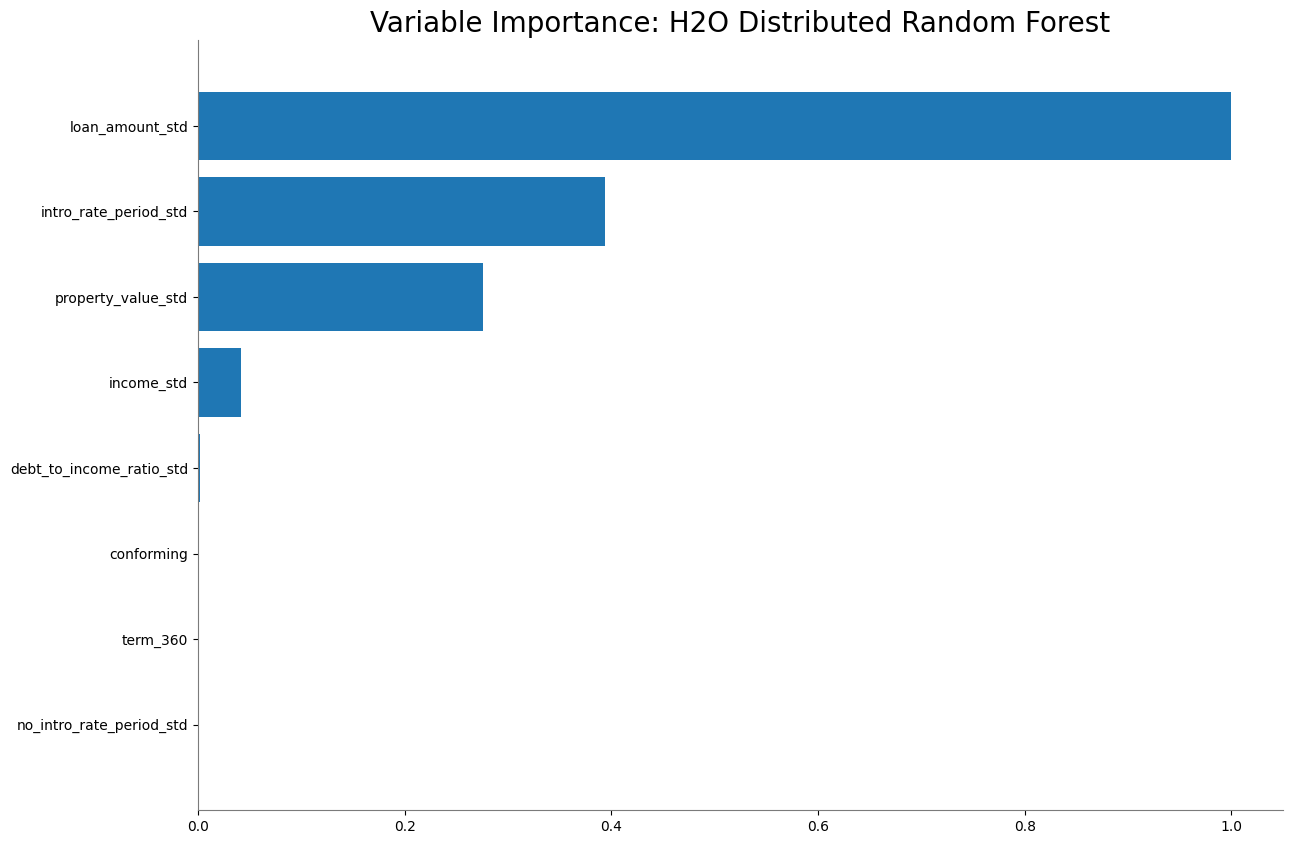

<Figure size 640x480 with 0 Axes>

In [22]:
stolen_dt.varimp_plot()

These are the most important variables in the stolen model, and likely in the real model too.

#### Assess accuracy of stolen model

In [23]:
stolen_dt.cross_validation_metrics_summary() # h2o makes cv evaluation metrics available

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
aic,nan,0.0,nan,nan,nan
loglikelihood,nan,0.0,nan,nan,nan
mae,0.0221819,0.0007298,0.0213526,0.0227261,0.0224671
mean_residual_deviance,0.0057461,0.0003094,0.0055018,0.0060940,0.0056426
mse,0.0057461,0.0003094,0.0055018,0.0060940,0.0056426
r2,0.2400146,0.0127767,0.2519018,0.2265036,0.2416383
residual_deviance,0.0057461,0.0003094,0.0055018,0.0060940,0.0056426
rmse,0.0757851,0.0020293,0.0741741,0.0780643,0.0751170
rmsle,0.0582723,0.0018181,0.0567224,0.0602735,0.0578211


The stolen model is accurate enough (R2=0.79, RMSE=0.06), and importantly, very stable.

In [24]:
rem_ebm.predict_proba(random_frame[rem_x_names])[:, 1]


array([6.96064220e-05, 1.14020132e-04, 4.21377723e-07, ...,
       9.70245454e-04, 1.79166806e-06, 3.18713050e-05])

## Use Stolen Model to Craft Adversarial Examples

#### Use stolen model to find seed rows for adversary searches

In [25]:
# Find low-prediction seed row based on rules from stolen model
low_adversary_seed = random_frame.loc[
    (random_frame['intro_rate_period_std'] >= 4.63) &
    (random_frame['loan_amount_std'] < -1.25) &
    (random_frame['property_value_std'] >= -0.9)
].mean()

# Add interaction terms to the seed
low_adversary_seed['loan_to_value'] = low_adversary_seed['loan_amount_std'] / (low_adversary_seed['property_value_std'] + 1e-6)
low_adversary_seed['income_dti_ratio'] = low_adversary_seed['income_std'] / (low_adversary_seed['debt_to_income_ratio_std'] + 1e-6)

print("Low adversarial example seed row:")
print(low_adversary_seed)
print("\n")

# Find high-prediction seed row
high_adversary_seed = random_frame.loc[
    (random_frame['intro_rate_period_std'] < 2.26) &
    (random_frame['income_std'] < 233) &
    (random_frame['property_value_std'] < -0.8)
].mean()

# Add interaction terms to the seed
high_adversary_seed['loan_to_value'] = high_adversary_seed['loan_amount_std'] / (high_adversary_seed['property_value_std'] + 1e-6)
high_adversary_seed['income_dti_ratio'] = high_adversary_seed['income_std'] / (high_adversary_seed['debt_to_income_ratio_std'] + 1e-6)

print("High adversarial example seed row:")
print(high_adversary_seed)


Low adversarial example seed row:
term_360                     0.908497
conforming                   0.928105
no_intro_rate_period_std    -0.392157
loan_amount_std             -3.233388
intro_rate_period_std        6.443513
property_value_std           3.921597
income_std                  22.749613
debt_to_income_ratio_std     1.066510
loan_to_value               -0.824508
income_dti_ratio            21.330870
dtype: float64


High adversarial example seed row:
term_360                     0.899583
conforming                   0.900887
no_intro_rate_period_std    -0.419405
loan_amount_std              5.184228
intro_rate_period_std        0.940931
property_value_std          -3.204231
income_std                  19.908327
debt_to_income_ratio_std     0.987480
loan_to_value               -1.617932
income_dti_ratio            20.160723
dtype: float64


#### Perturb seed row to find low scoring adversarial examples

In [26]:
# Full feature list (original + interactions)
full_feature_list = list(schema_dict.keys()) + ['loan_to_value', 'income_dti_ratio']

# Init result frame with all 10 features
low_adversary_frame = pd.DataFrame(columns=full_feature_list)

# Quantiles to explore
low_quantiles = [0.01, 0.05, 0.1, 0.25, 0.5]
high_quantiles = [0.99, 0.95, 0.9, 0.75, 0.5]

idx = 0

# Loop to generate adversarial examples
for a in random_frame['property_value_std'].quantile(high_quantiles):
    for b in random_frame['intro_rate_period_std'].quantile(high_quantiles):
        for c in random_frame['debt_to_income_ratio_std'].quantile(low_quantiles):
            for d in random_frame['term_360'].quantile(low_quantiles):
                # Copy the seed
                seed_copy = low_adversary_seed.copy()
                seed_copy['property_value_std'] = a
                seed_copy['intro_rate_period_std'] = b
                seed_copy['debt_to_income_ratio_std'] = c
                seed_copy['term_360'] = d
                # Recompute interaction terms
                seed_copy['loan_to_value'] = seed_copy['loan_amount_std'] / (seed_copy['property_value_std'] + 1e-6)
                seed_copy['income_dti_ratio'] = seed_copy['income_std'] / (seed_copy['debt_to_income_ratio_std'] + 1e-6)
                # Append to result frame
                low_adversary_frame.loc[idx] = seed_copy[full_feature_list]
                idx += 1

# Preview results
low_adversary_frame.head()


,term_360,conforming,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,loan_to_value,income_dti_ratio
0,0.0,0.928105,-0.392157,-3.233388,9.20682,17.291027,22.749613,-1.318866,-0.186998,-17.249385
1,0.0,0.928105,-0.392157,-3.233388,9.20682,17.291027,22.749613,-1.318866,-0.186998,-17.249385
2,1.0,0.928105,-0.392157,-3.233388,9.20682,17.291027,22.749613,-1.318866,-0.186998,-17.249385
3,1.0,0.928105,-0.392157,-3.233388,9.20682,17.291027,22.749613,-1.318866,-0.186998,-17.249385
4,1.0,0.928105,-0.392157,-3.233388,9.20682,17.291027,22.749613,-1.318866,-0.186998,-17.249385


#### Perturb seed row to find high scoring adversarial examples

In [27]:
# Full feature list including interactions
full_feature_list = list(schema_dict.keys()) + ['loan_to_value', 'income_dti_ratio']

# Init result frame
high_adversary_frame = pd.DataFrame(columns=full_feature_list)

idx = 0

# Generate adversarial examples from high-prediction seed
for a in random_frame['property_value_std'].quantile(low_quantiles):
    for b in random_frame['intro_rate_period_std'].quantile(low_quantiles):
        for c in random_frame['debt_to_income_ratio_std'].quantile(high_quantiles):
            for d in random_frame['term_360'].quantile(high_quantiles):
                # Copy the seed safely
                seed_copy = high_adversary_seed.copy()
                seed_copy['property_value_std'] = a
                seed_copy['intro_rate_period_std'] = b
                seed_copy['debt_to_income_ratio_std'] = c
                seed_copy['term_360'] = d
                # Recalculate interactions
                seed_copy['loan_to_value'] = seed_copy['loan_amount_std'] / (seed_copy['property_value_std'] + 1e-6)
                seed_copy['income_dti_ratio'] = seed_copy['income_std'] / (seed_copy['debt_to_income_ratio_std'] + 1e-6)
                # Append to frame
                high_adversary_frame.loc[idx] = seed_copy[full_feature_list]
                idx += 1

# View top rows
high_adversary_frame.head()


,term_360,conforming,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,loan_to_value,income_dti_ratio
0,1.0,0.900887,-0.419405,5.184228,0.02097,-4.944679,19.908327,3.316528,-1.048446,6.002759
1,1.0,0.900887,-0.419405,5.184228,0.02097,-4.944679,19.908327,3.316528,-1.048446,6.002759
2,1.0,0.900887,-0.419405,5.184228,0.02097,-4.944679,19.908327,3.316528,-1.048446,6.002759
3,1.0,0.900887,-0.419405,5.184228,0.02097,-4.944679,19.908327,3.316528,-1.048446,6.002759
4,1.0,0.900887,-0.419405,5.184228,0.02097,-4.944679,19.908327,3.316528,-1.048446,6.002759


#### Second call to blackbox API to test adversarial examples

In [28]:
# combine potential adversaries so only one call to API is needed
adversaries = pd.concat([low_adversary_frame, high_adversary_frame], axis=0)

# score potential adversarial examples to understand their effect on generated predictions
blackbox_adversaries_phat = pd.DataFrame(rem_ebm.predict_proba(adversaries[rem_x_names])[:, 1], columns=['phat'])
blackbox_adversaries_phat = pd.concat([adversaries.reset_index(drop=True), blackbox_adversaries_phat], axis=1)
blackbox_adversaries_phat.sort_values(by='phat')

,term_360,conforming,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,loan_to_value,income_dti_ratio,phat
16,0.0,0.928105,-0.392157,-3.233388,9.20682,17.291027,22.749613,0.327762,-0.186998,69.408733,5.778442e-12
15,0.0,0.928105,-0.392157,-3.233388,9.20682,17.291027,22.749613,0.327762,-0.186998,69.408733,5.778442e-12
19,1.0,0.928105,-0.392157,-3.233388,9.20682,17.291027,22.749613,0.327762,-0.186998,69.408733,6.985731e-12
18,1.0,0.928105,-0.392157,-3.233388,9.20682,17.291027,22.749613,0.327762,-0.186998,69.408733,6.985731e-12
17,1.0,0.928105,-0.392157,-3.233388,9.20682,17.291027,22.749613,0.327762,-0.186998,69.408733,6.985731e-12
...,...,...,...,...,...,...,...,...,...,...,...
698,1.0,0.900887,-0.419405,5.184228,0.22140,-4.944679,19.908327,1.019746,-1.048446,19.522810,7.078929e-02
697,1.0,0.900887,-0.419405,5.184228,0.22140,-4.944679,19.908327,1.019746,-1.048446,19.522810,7.078929e-02
696,1.0,0.900887,-0.419405,5.184228,0.22140,-4.944679,19.908327,1.019746,-1.048446,19.522810,7.078929e-02
1196,1.0,0.900887,-0.419405,5.184228,0.22140,-1.550316,19.908327,1.019746,-3.343984,19.522810,7.078929e-02


We now have many adversarial examples that can reliably evoke extremely low and high enough predictions from the blackbox API. These can most easily be used to falsify a loan application to recieve a low-priced loan (using low adversaries). Or they could be used to ensure someone else recievces a high-priced loan.

#### End timer

In [29]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 1475.49 s.


#### Shutdown H2O

In [30]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_8436 closed.
